In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Task2_v2')

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import torch

from net import *
from dataset import *

import os

In [4]:
import IPython
IPython.display.display(IPython.display.Javascript('google.colab.kernel.invokeFunction("save")'))

<IPython.core.display.Javascript object>

In [ ]:
models = []
seeds = [10, 11, 12]


channels = ['Z','X','Y']  # все 3 канала для обучения
train_fraction = 0.8  # доля сэмплов для обучения
selected_sensors_num = 2016 # все сенсоры
batch_size = 16
epochs = 50
learning_rate = 0.001
num_sources_points = [0,1] # 2 точки удара для обучения
path=r'/content/drive/MyDrive/Task2_v2/data/'
path_to_input_batch = path+r'14m/batch_14m.hdf5'
path_to_output_batch = path+r'9m/batch_9m.hdf5'
path_sensors_file = path+'sensors_data.txt' # координаты сенсоров
path_sources_file = path+'points_data.txt' # координаты точек удара

In [6]:
with open(path_sensors_file) as f:
    sensors_names = [line.split()[0] for line in f]

In [7]:
data = MicroseismDataset(input_batch=path_to_input_batch,
                         output_batch=path_to_output_batch,
                         selected_sensors_names=sensors_names[:selected_sensors_num],
                         number_sources_points = num_sources_points,
                         sensors_names=sensors_names,
                         channels=channels,
                         sensors_path=path_sensors_file,
                         points_path=path_sources_file)

train_size = int(train_fraction * len(data))
val_size = len(data) - train_size

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UnetWithFeatures()
model.to(device)

UnetWithFeatures(
  (enc1): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (enc3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (dec1): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (dec2): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (dec3): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (feature_conv): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (combine): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
)

In [9]:
for seed in seeds:
    print(f"Обучение модели с seed = {seed}")

    torch.manual_seed(seed)
    generator = torch.Generator().manual_seed(seed)
    train_data, val_data = random_split(data, [train_size, val_size], generator=generator)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = UnetWithFeatures().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.L1Loss()

    train_loss = []
    val_loss = []
    best_val = float('inf')
    early_stopping_counter = 0
    patience = 5

    start_time = time.time()

    for epoch in range(epochs):
        batch_train_loss = []
        batch_val_loss = []

        model.train()
        for inputs, output, f in train_dataloader:
            inputs = inputs.float().to(device)
            output = output.float().to(device)
            f = f.float().to(device)

            predicted_output = model(inputs, f)
            loss = criterion(predicted_output, output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_train_loss.append(loss.item())

        model.eval()
        with torch.no_grad():
            for inputs, output, f in val_dataloader:
                inputs = inputs.float().to(device)
                output = output.float().to(device)
                f = f.float().to(device)

                predicted_output = model(inputs, f)
                loss = criterion(predicted_output, output)
                batch_val_loss.append(loss.item())

        train_epoch = np.mean(batch_train_loss)
        val_epoch = np.mean(batch_val_loss)
        train_loss.append(train_epoch)
        val_loss.append(val_epoch)

        print(f'[seed {seed}] epoch {epoch}, train_loss {train_epoch:.6f}, val_loss {val_epoch:.6f}')

        if val_epoch < best_val:
            best_val = val_epoch
            early_stopping_counter = 0
            torch.save(model.state_dict(), f"best_model_seed{seed}.pth")
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Task2_v2/best_model_seed{seed}.pth")
            print("Лучшая модель сохранена")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping на эпохе {epoch} (patience={patience})")
                break

    end_time = time.time()
    print(f"Время обучения модели seed {seed}: {end_time - start_time:.2f} сек.")
    models.append(model)

Обучение модели с seed = 10
[seed 10] epoch 0, train_loss 0.024096, val_loss 0.022902
Лучшая модель сохранена
[seed 10] epoch 1, train_loss 0.021913, val_loss 0.022036
Лучшая модель сохранена
[seed 10] epoch 2, train_loss 0.021192, val_loss 0.022061
[seed 10] epoch 3, train_loss 0.020889, val_loss 0.021067
Лучшая модель сохранена
[seed 10] epoch 4, train_loss 0.020612, val_loss 0.020961
Лучшая модель сохранена
[seed 10] epoch 5, train_loss 0.020410, val_loss 0.020718
Лучшая модель сохранена
[seed 10] epoch 6, train_loss 0.020260, val_loss 0.020386
Лучшая модель сохранена
[seed 10] epoch 7, train_loss 0.020140, val_loss 0.020730
[seed 10] epoch 8, train_loss 0.020025, val_loss 0.020560
[seed 10] epoch 9, train_loss 0.019941, val_loss 0.020573
[seed 10] epoch 10, train_loss 0.019884, val_loss 0.020102
Лучшая модель сохранена
[seed 10] epoch 11, train_loss 0.019809, val_loss 0.020222
[seed 10] epoch 12, train_loss 0.019764, val_loss 0.020124
[seed 10] epoch 13, train_loss 0.019717, val_lo

In [10]:
# Ансамблевое предсказание на валидации после обучения всех моделей
print("Ансамблевое предсказание на validation")
maes = []
all_targets = []
all_preds = []

with torch.no_grad():
    for x_batch, y_batch, f_batch in DataLoader(val_data, batch_size=batch_size):
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        f_batch = f_batch.float().to(device)

        ensemble_outputs = []
        for seed in seeds:
            m = UnetWithFeatures().to(device)
            m.load_state_dict(torch.load(f"best_model_seed{seed}.pth", map_location=device))
            m.eval()
            pred = m(x_batch, f_batch)
            ensemble_outputs.append(pred)

        ensemble_output = torch.stack(ensemble_outputs, dim=0).mean(dim=0)
        mae = torch.mean(torch.abs(ensemble_output - y_batch)).item()
        maes.append(mae)
        all_targets.append(y_batch.cpu().numpy())
        all_preds.append(ensemble_output.cpu().numpy())

final_mae = np.mean(maes)
print(f"Среднее MAE ансамбля по всей валидации: {final_mae:.6f}")

Ансамблевое предсказание на validation
Среднее MAE ансамбля по всей валидации: 0.018749


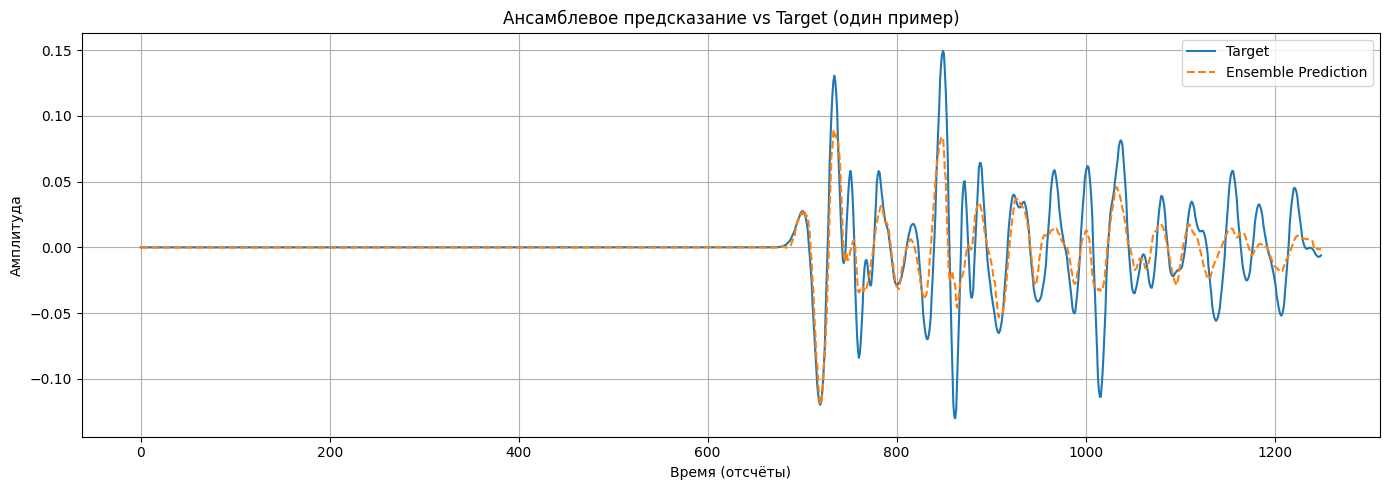

In [11]:
target_sample = all_targets[0][7][0] #номер батча, номер сэмпла, сигнал
pred_sample = all_preds[0][7][0]

plt.figure(figsize=(14, 5))
plt.plot(target_sample, label="Target")
plt.plot(pred_sample, label="Ensemble Prediction", linestyle="--")
plt.title("Ансамблевое предсказание vs Target (один пример)")
plt.xlabel("Время (отсчёты)")
plt.ylabel("Амплитуда")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
IPython.display.display(IPython.display.Javascript('google.colab.kernel.invokeFunction("save")'))

<IPython.core.display.Javascript object>

In [13]:
# # Предсказание на 3-й точке удара (number_sources_points = 2)


# predict_dataset = MicroseismDataset(
#     input_batch=path_to_input_batch,
#     output_batch=path_to_output_batch,
#     selected_sensors_names=sensors_names[:selected_sensors_num],
#     number_sources_points=[2],
#     sensors_names=sensors_names,
#     channels=channels,
#     sensors_path=path_sensors_file,
#     points_path=path_sources_file
# )
# predict_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# maes = []
# all_preds = []
# all_targets = []

# with torch.no_grad():
#     for x, y, f in predict_loader:
#         x = x.float().to(device)
#         y = y.float().to(device)
#         f = f.float().to(device)

#         ensemble_outputs = []
#         for seed in seeds:
#             m = UnetWithFeatures().to(device)
#             m.load_state_dict(torch.load(f"best_model_seed{seed}.pth", map_location=device))
#             m.eval()
#             pred = m(x, f)
#             ensemble_outputs.append(pred)

#         ensemble_output = torch.stack(ensemble_outputs, dim=0).mean(dim=0)
#         mae = torch.mean(torch.abs(ensemble_output - y)).item()
#         maes.append(mae)

#         all_targets.append(y.cpu().numpy())
#         all_preds.append(ensemble_output.cpu().numpy())

# print("MAE ансамбля на 3-й точке удара:", np.mean(maes))